<h1><center><br/>Observing Celestial Objects</center></h1>

<img src="https://docs.google.com/uc?export=download&id=1KXvgEdXdJ2uxEXukaH5RoDTEPDX9iHak" width="40%">

<font size="3">
    <center>
        Jason D. Stock
        <br/>
        <br/>
        <i>Colorado State University</i>
        <br/>
        <i>December 8<sup>th</sup>, 2018</i>
    </center>
</font>

--- 

# Contents
&emsp;&emsp;<b style="font-weight:500">1</b>&emsp;[Introduction](#1&emsp;Introduction)  
&emsp;&emsp;<b style="font-weight:500">2</b>&emsp;[Data Exploration](#2&emsp;Data-Exploration)  
&emsp;&emsp;&emsp;&emsp;<b style="font-weight:500">2.1</b>&emsp;[Data Features](#2.1&emsp;Data-Features)  
&emsp;&emsp;&emsp;&emsp;<b style="font-weight:500">2.2</b>&emsp;[Numerical Analysis](#2.2&emsp;Numerical-Analysis)  
&emsp;&emsp;<b style="font-weight:500">3</b>&emsp;[Neural Networks](#3&emsp;Neural-Networks)  
&emsp;&emsp;&emsp;&emsp;<b style="font-weight:500">3.1</b>&emsp;[Scaled Conjugate Gradient](#3.1&emsp;Scaled-Conjugate-Gradient)  
&emsp;&emsp;&emsp;&emsp;<b style="font-weight:500">3.2</b>&emsp;[PyTorch](#3.2&emsp;PyTorch)  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;<b style="font-weight:500">3.2.1</b>&emsp;[Stochastic Gradient Decent](#3.2.1&emsp;Stochastic-Gradient-Decent)  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;<b style="font-weight:500">3.2.2</b>&emsp;[Adaptive Moment Estimation](#3.2.2&emsp;Adaptive-Moment-Estimation)  
&emsp;&emsp;<b style="font-weight:500">4</b>&emsp;[Application](#4&emsp;Application)  
&emsp;&emsp;<b style="font-weight:500">5</b>&emsp;[Conclusion](#5&emsp;Conclusion)  
&emsp;&emsp;<b style="font-weight:500">6</b>&emsp;[Resources](#6&emsp;Resources)  

# 1&emsp;Introduction

Throughout time, many questions have been developed relating to the universe in which we live. The contributions from the scientific community and researchers alike have provided great work to allow a better understanding and information to answer these questions. An example of many is seen with the [Sloan Digital Sky Survey (SDSS)](https://www.sdss.org) - a major multi-spectral imaging and spectroscopic redshift survey that is mapping the night sky. A project that includes collecting relative coordinates, absolute brightness, redshift, magnitude, and more on celestial objects.  

This notebook will explore a subset of their data to understand which features construct specific celestial objects, and how they can be used to classify one from another.  Use of statistical analysis and neural networks can assist answer these questions, and be used to build an accurate model built from a neural network that can be used with new information to deduce information about the universe.

# 2&emsp;Data Exploration

There are various dependencies for use of this notebook labeled in the import sections below.  Foremost, the SDSS data needs to be downloaded and imported to the current working directory.  For this, data was directly queried via the SDSS Database Server with the following SQL query:

~~~ sql
-- This query does a table JOIN between the imaging (PhotoObj) and spectra
-- (SpecObj) tables and includes the necessary columns in the SELECT to upload
-- the results to the SAS (Science Archive Server) for FITS file retrieval.
SELECT TOP 500000
   p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z,
   p.run, p.rerun, p.camcol, p.field,
   s.specobjid, s.class, s.z as redshift,
   s.plate, s.mjd, s.fiberid
FROM PhotoObj AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE 
   p.u BETWEEN 0 AND 19.6
   AND g BETWEEN 0 AND 20
~~~

The response is formatted to a CSV file named SkyData.csv for ease of use.  In Python, Pandas `read_csv` function helps contain the data in a DataFrame.

In [1]:
import matplotlib.pylab as plt
import mlutils as ml
import neuralnetworks as nn
import numpy as np 
import pandas as pd
import random
import seaborn as sns
import scipy.constants 
import scipy.stats
import time
import warnings
import collections

from matplotlib.pyplot import cm
from ipywidgets import FloatProgress
from IPython.display import display
from pprint import pprint

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 2.1&emsp;Data Features

Rather than looking at all 500,000 samples of data, the first five displayed are used to give a good indication of the columns.  The data is packed with information from imagery and spectra data to coordinate approximations.  These are defined by below.

In [2]:
data = pd.read_csv('SkyData.csv', sep=',', low_memory=False)

In [3]:
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237648721767104684,178.916132,0.369850,19.18494,17.28407,16.41079,16.00360,15.70586,756,301,4,421,320977438219724800,GALAXY,0.065127,285,51930,349
1,1237648721768022143,180.962195,0.342646,17.52684,15.85701,15.21702,14.96524,14.85095,756,301,4,435,3256236472499464192,STAR,-0.000156,2892,54552,487
2,1237648721768022137,180.959776,0.416301,17.77226,16.47326,15.96202,15.75909,15.66772,756,301,4,435,3256234823232022528,STAR,0.000388,2892,54552,481
3,1237648721768022132,180.953075,0.307552,19.01313,17.71921,17.16157,16.92821,16.82746,756,301,4,435,3284392491452753920,STAR,0.000469,2917,54556,518
4,1237648721768022028,180.899848,0.417192,18.12065,17.09130,16.80376,16.70857,16.69069,756,301,4,435,3256231249819232256,STAR,0.000050,2892,54552,468


* **objid**: Unique object ID
* **ra**: Right ascension, $\mu$ [hours, minutes, and seconds]
* **dec**: Declination, $\nu$ [degrees, arcminutes, and arcseconds]  

Right ascension refers to the angular distance of a particular point measured eastward along the celestial equator from the Sun on the vernal equinox to a particular point above the Earth.  Declination is the angular distance of an object on the celestial sphere in the equatorial coordinate system.  Together, these coordinates can be used to describe a position similar to latitude and longitude, but extending into space.  It is so that any particular object has the same celestial coordinates for all observers on Earth.

* **u**: Ultraviolet, $\Delta \lambda = 3543 Å$
* **g**: Green, $\Delta \lambda = 4770 Å$
* **r**: Red, $\Delta \lambda = 6231 Å$
* **i**: Near Infrared, $\Delta \lambda = 7625 Å$
* **z**: Infrared, $\Delta \lambda = 9134 Å$

Color of an object is defined by the difference in magnitude between electromagnetic spectra.  Astronomical magnitude refers to the brightness of a stellar object, such that the higher numbers correspond to fainter objects, and lower numbers to those that are brighter.  These magnitudes correspond to specific bands of light following the Gunn-Thuan griz system that was employed by the SDSS.  Thus, telescopes use filters to capture light in  green ($g$), red ($r$), and those not on the visible spectrum; ultraviolet ($u$), and two infrared wavelengths ($i$ and $z$) all in units of Angstroms[1].  

Wavelength(s) can give an indication to what the composition, temperature, color, and other physical attributes are for that object.  The color index for some object is calculated by taking the difference of magnitude in the various filters, e.g., a star with a high $g-r$ value will appear more red then than one with a low $g-r$ value, and thus allowing the effective temperature to be determined.  A popular application of calculating magnitude differences is to display and analyze color-color graphs to target outliers on the main-sequence in the data.  This technique has been used to identify ultra-cool subdwarfs, binary stars, quasars, etc.  It is evident that all objects radiate energy at various wavelengths and the plethora of stars, galaxies, and quasars may differentiate on this spectrum, i.e., may be good features to further explore.

* **run**:  Run number
* **rerun**: Rerun number
* **camcol**: Camera column
* **field**: Field number  

These four features are tied together; such that the run number is used to identify a specific scan where the camcol identifies the scanline within a run (typically a number between 1-6), and each camcol is artificially broken down into a series of overlapping fields that consists of the frames of the $u, g, r, i, z$ filters for the same region in the sky [2].  Simply, these fields relate to camera configurations for each shot which is not as important for this notebook.

* **specobjid**: Unique ID for optical spectroscopic objects
* **class**:  Photometric classification

The specobjid encodes information about the plate, mjd, and fiberid for spectroscopic objects.  Though, a more important identifier is the class, or classification, that is used to assign a *type* (star, galaxy, or quasar) to each object.  The class will be of importance as this notebook will discover a variety of features to classify these objects.

* **redshift**: Photometric redshift  

In order to understand the properties of redshift, the basics of light need to be understood.  Light is a wave constructed by an oscillating electric and a perpendicular magnetic field that has a wavelength, frequency, and speed. The various types of electromagnetic waves (ultraviolet, infrared, visible light, etc) differ only in variations in wavelength and frequency defined by the equation $c = \lambda f$ where $c$ is the speed of light in a vacuum.  The speed of light can be derived by Maxwell's Equations, and specifically by the wave equations for electromagnetic waves where the component for an electric field and a magnetic field define the permittivity of free space ($\varepsilon_0$) and permeability of free space ($\mu_0$) respectively.  Thus, relating to the equation $c = 1/\sqrt{\mu_0\varepsilon_0}$, displaying $c$ as a fundamental constant in a vacuum, thereby showing the original proposition that electromagnetic waves differ *only* by their wavelength and frequency.  

This is of importance since redshift can be defined when light is shifted towards the red end of the spectrum, i.e., towards lower frequencies, for all objects traveling away from Earth.  Therefore, there is a shift in frequency by $c = \lambda f$  as a light wave travels relative to a given observer.  This observation is further defined as the Relativistic Doppler Effect [4].  

It is explained by a relative-velocity phenomenon that as the universe expands the speed of an object is proportional to its distance, defined by Hubble's Law - which can be computed as measurements of redshift are taken.  Since the majority of stars are observed in the Milky Way and galaxies are seen to be further in the sky, etc., it is likely that redshift magnitude relationships can be used to describe various objects in individual photometric classes, i.e., stars galaxies, and quasars.

* **plate**: Plate number
* **mjd**: Modified Julian Date
* **fiberid**:  Fiber ID

The SDSS spectrograph uses optical fibers to direct light at the focal plane from individual objects to the slithead.  For each exposure objects are assigned corresponding fiber ID's. A unique plate is set to position the optical fibers that feed into the spectrographs.  Once an image or spectrum is taken, a date and time is recorded [3].  Similar to the run, camera column, and field these features relate most to the camera configuration and will not be explored in this notebook.

### 2.2&emsp;Numerical Analysis

Collectively, the sample data from SDSS details a total of 500,000 objects of the class GALAXY, STAR, and QSO.  Some of the features by definition show to be of more importance than others, i.e., $u, g, r, i, z, \text{and } redshift$ will be further considered for classifying each class.

In [4]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 18 columns):
objid        500000 non-null int64
ra           500000 non-null float64
dec          500000 non-null float64
u            500000 non-null float64
g            500000 non-null float64
r            500000 non-null float64
i            500000 non-null float64
z            500000 non-null float64
run          500000 non-null int64
rerun        500000 non-null int64
camcol       500000 non-null int64
field        500000 non-null int64
specobjid    500000 non-null uint64
class        500000 non-null object
redshift     500000 non-null float64
plate        500000 non-null int64
mjd          500000 non-null int64
fiberid      500000 non-null int64
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 68.7+ MB


All of the columns are displayed showing the total number of non-null entries data types and the total memory usage.  Subsequently, there appear to be no missing values in the range of entries - which is great!  A summary of the data is described below; displaying descriptive statistics that summarize the central tendency, dispersion and shape of the data's distribution.  This will properly be displayed in sections below.

In [5]:
data.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.0,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.237659e+18,184.609047,26.701782,18.639578,17.404906,16.874612,16.573492,16.372911,3184.455678,301.0,3.493806,191.770658,2.287559e+18,0.169630,2031.677928,53509.282640,338.537562
std,4.751024e+12,69.826568,20.902576,0.832731,0.984441,1.129197,20.067479,28.356798,1106.188066,0.0,1.594195,143.174457,1.850047e+18,0.430658,1643.160742,1288.151219,205.138360
min,1.237646e+18,0.002795,-11.252825,6.752484,7.466997,8.449127,-9999.000000,-9999.000000,94.000000,301.0,1.000000,11.000000,2.994897e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237655e+18,146.387666,7.112737,18.218737,16.851960,16.194050,15.862168,15.619250,2326.000000,301.0,2.000000,85.000000,1.065249e+18,0.000045,946.000000,52522.000000,167.000000
50%,1.237661e+18,186.609345,28.720064,18.873825,17.521935,16.897870,16.599300,16.420760,3530.000000,301.0,4.000000,157.000000,1.866913e+18,0.051609,1658.000000,53173.000000,332.000000
75%,1.237663e+18,225.598357,43.643623,19.272270,18.053130,17.571010,17.317392,17.199280,3970.000000,301.0,5.000000,257.000000,2.690911e+18,0.097635,2390.000000,54437.000000,497.000000
max,1.237667e+18,359.998882,79.742295,19.600000,19.996050,33.209920,32.349170,30.846780,5080.000000,301.0,6.000000,986.000000,1.013665e+19,7.009400,9003.000000,57520.000000,1000.000000


While there appear to be no missing or *null-values*, the spectral types, $u,g,r,i,z$, indicates a value of -9999.00 place holding possible inconsistent entries.  To handle this, all samples with a value of -9999.00 are dropped from the dataset before sampling.

It was decided that the dataset will be balanced to contain an equal number of samples for each class (GALAXY/STAR/QSO).  Reasoning for this was twofold, i.e., to get a more equal distribution and simplify the computation in the analysis below. It is understood that dropping samples removes possible artifacts, or outliers that can be used in classification.  However, nearly 52,000 samples for each class is quite manageable and diverse.

In [6]:
print(data['class'].value_counts(), '\n' + '-'*25)

data = data[(data != -9999.0).all(1)]
_, c = np.unique(data['class'], return_counts=True)

data = data.sort_values(by=['class'])[c[0] - c[1] : c[0] + c[1]*2] \
           .sample(frac=1).reset_index(drop=True)

print(data['class'].value_counts())

GALAXY    274517
STAR      173684
QSO        51799
Name: class, dtype: int64 
-------------------------
STAR      51799
QSO       51799
GALAXY    51799
Name: class, dtype: int64


A lot of the information provided in the dataset relates to spectrograph and imagery configurations.  Thus, the spectral types and redshift values will be examined as potential features.  Analyzing these will offer a better indication to how these features contribute to the machine learning algorithms in the upcoming sections.  Features were divided to see individual results by class, and displayed using various libraries from Seaborn; a statistical visualization package wrapped around matplotlib.  

The Pearson's Correlation Coefficient is displayed in the heatmap shown below as a color encoded matrix representing correlation across the features.  The correlation coefficient justifies values between -1 and 1, where a value approaching 1 is positively or strongly correlated and value approaching -1 is negatively or weakly correlated.  The heatmap, while annotated, easily shows this for each class by showing positive correlated features with a dark value, and light for those with negative correlation.  

Each matrix is a symmetric matrix with trivial correlation on the diagonal - which can be focused to the lower-triangular portion of the matrix.  The spectral magnitudes show a positive correlation increasing with wavelength, i.e., the near infrared, $i$, and infrared, $z$, filters are more correlated than the green, $g$, and infrared, $z$, filters.  Not only do these wavelengths fall closer to one another on the electromagnetic spectrum, but the system response of the filters described by the sensitivity to different wavelengths show adjacent overlap [5]. This can be seen in the figure of normalized responses of the SDSS system band-passes.  

Having multiple features with strong positive correlation, and thus, multicollinear could possibly yield widely varying models, or unreliable results.  However, since there is a descending correlation with decrease in wavelength and unique features, all spectra information will be used.  Contrary to this, redshift is near negatively correlated with each of the spectral magnitudes.  Most interestingly, the correlation between classes, i.e., stars, galaxies, and quasars, all vary with distinct coefficients.  This is a good indication that redshift may be beneficial to training predictive models.

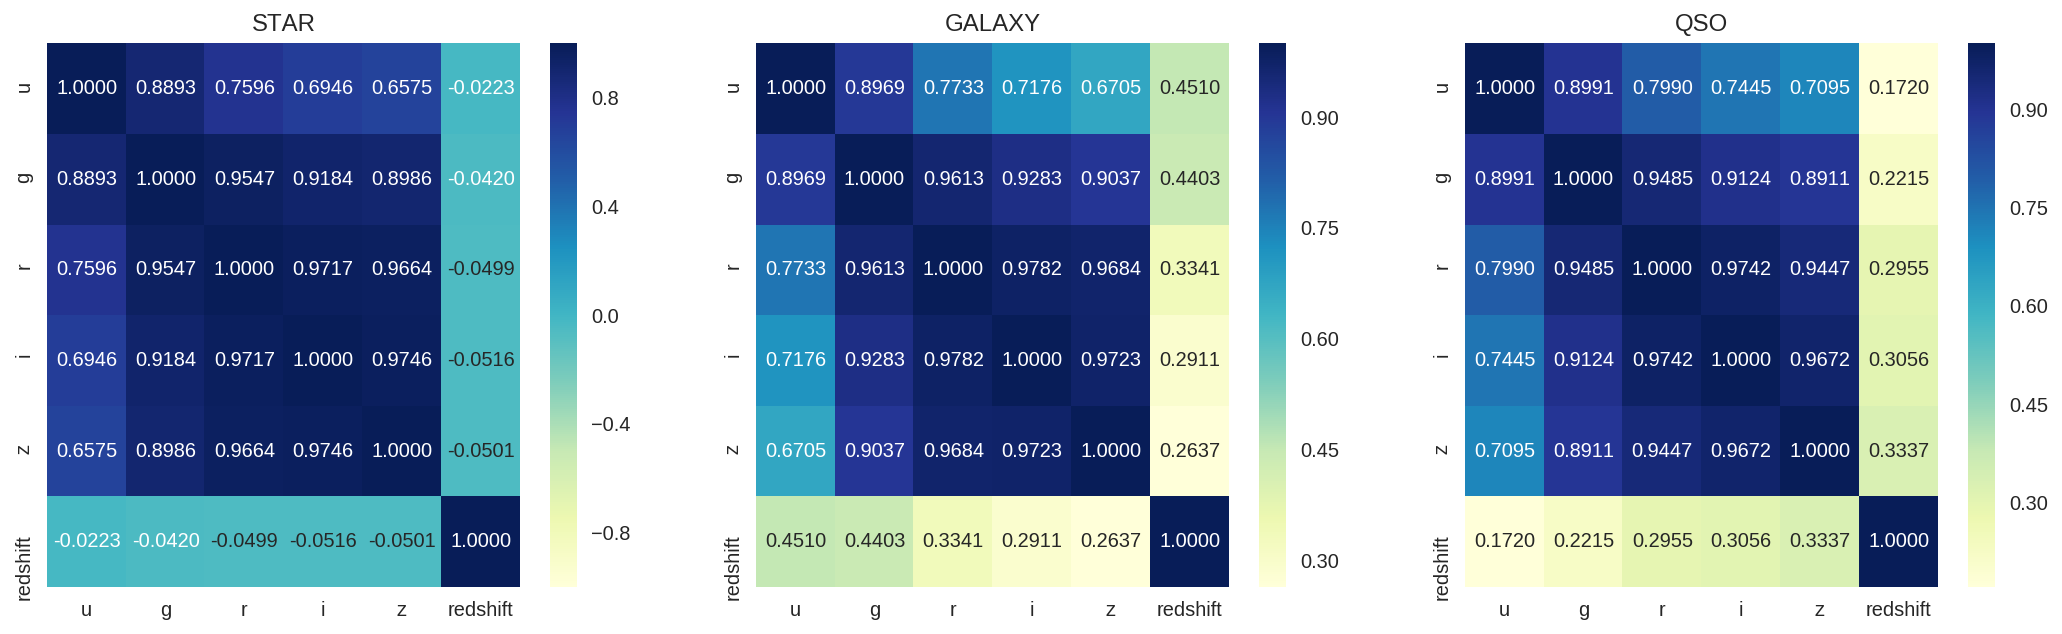

In [7]:
columns = ['u', 'g', 'r', 'i', 'z', 'redshift']

plt.figure(figsize=(18,5))
for i, v in enumerate(['STAR', 'GALAXY', 'QSO']):
    plt.subplot(1,3,i+1)
    corr = data[data['class'] == v][columns].corr(method='pearson')
    sns.heatmap(corr, annot=True, fmt='.4f', cmap='YlGnBu')
    plt.title(v)

plt.show()

<img src="https://docs.google.com/uc?export=download&id=1rjXRBcy9IBfTnKv5Mz1n_J-ACslIL1q3" width="88%"/>
[6] Bessel, M.S. 2005, ARA&A, 43, 293

Descriptive statistics are projected to distribution and probability kernel density plots. Placing these side by side, split by feature, is effective by showing a comparison across the various classes.  The six total features are plotted showing the mean, $\mu$, and standard deviation, $\sigma$, in the title across ever class.  Each violin plot shows a white dot for the mean value for that class.  Extending vertically are the quartiles of the distribution, some more narrow than others.  Horizontal width represents the density, or frequency, of samples across different values for that feature.  Mathematically there is more happening in computing these graphs, but out of scope for this notebook.   

Initial observations of the spectra information show quasars with higher mean values with narrow interquartile ranges (as indicated by the quartile ranges), and higher kernel density estimation frequencies.  This shows higher magnitudes specific to quasars repeatedly captured and not for others - a potential advantage for machine learning algorithms.  Stars and galaxies carry attributes that again differentiate one another that may be advantageous as well.  As for redshift, it is difficult to visualize the relationship for each summary via violin plots, so further visualizations will be explored.

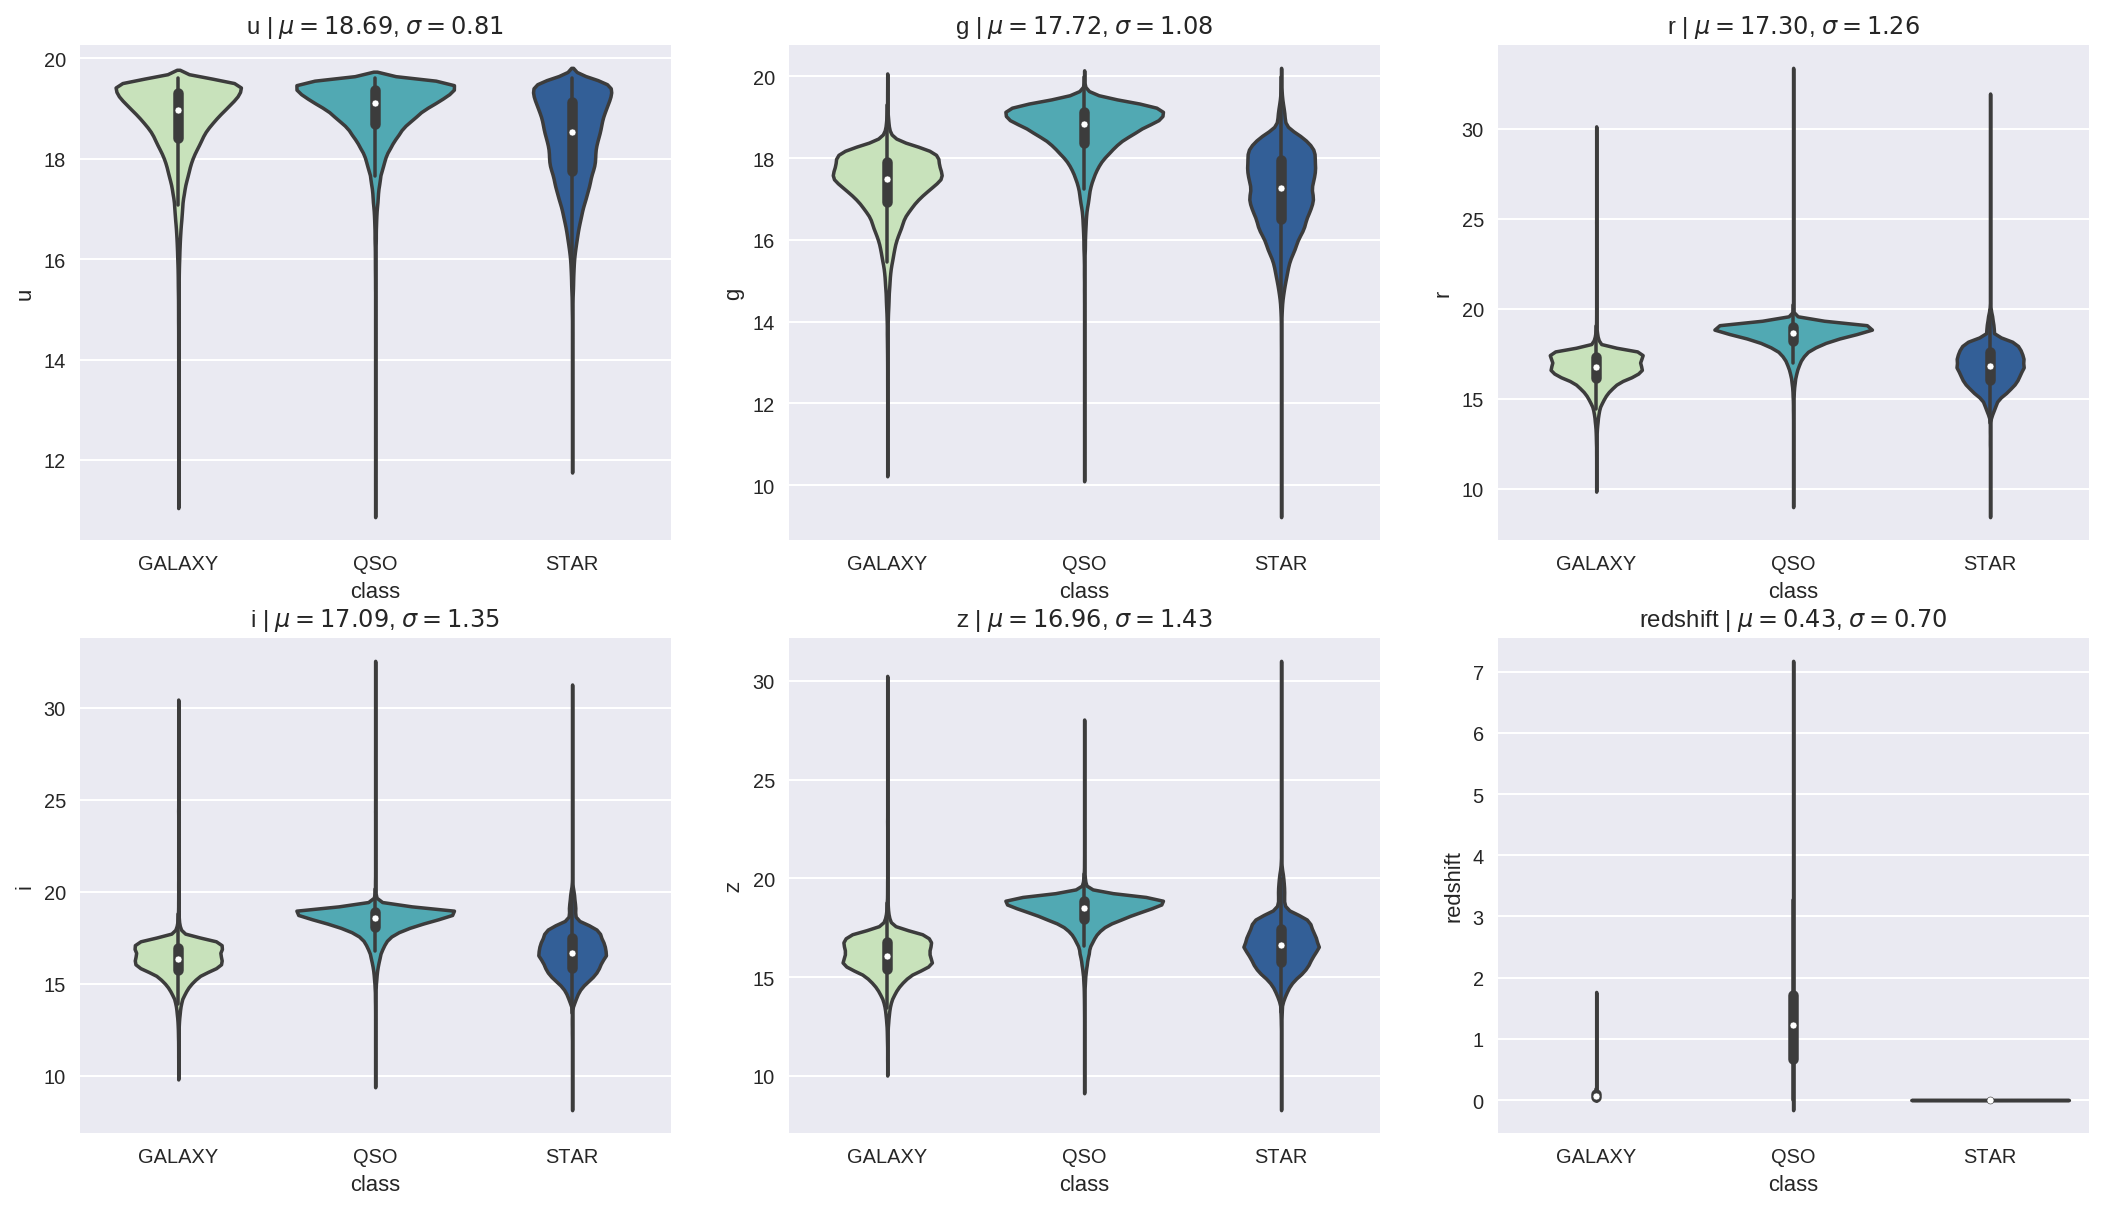

In [8]:
columns = ['u', 'g', 'r', 'i', 'z', 'redshift']

plt.figure(figsize=(18,10))

for i, v in enumerate(columns):
    plt.subplot(2,3,i+1)
    mu = np.mean(data[v])
    sigma = np.std(data[v])
    plt.title('{0} | $\mu={1:.2f}$, $\sigma={2:.2f}$'.format(v, mu, sigma))
    sns.violinplot(x='class', y=v, palette='YlGnBu', data=data);

plt.show()

The histograms below provide information for various applications including statistical reasonings, insight to the physics behind Hubble's Law, and other interstellar phenomena.  Similar to the violin plots, the mean, $\mu$, and standard deviation, $\sigma$, are displayed in the legend for each class. The classes from stars, galaxies, to quasars show an increase in mean value redshift.  Stars are normally distributed such that redshift is symmetric about a value of 0 with relatively small magnitudes.  Galaxies and quasars show a right-skewed distribution of positive values.  The difference resides primarily in the magnitude change over the various classes.  

This observation aligns with theories for cosmological expansion as discovered by Edwin Hubble.  It turns out that as the magnitude of redshift increases, so does the radial velocity for that object.  This is defined by the equation $v = cz \text{where } v$ is velocity, $c$ is the speed of light, and $z$ is measured redshift [7].  In later years Hubble discovered and proved relationships between radial velocity and the distance of far away objects, a relationship known to be Hubble’s Law [8].  

It can be seen that stars, the closest observable objects to Earth, have the lowest redshift values and radial velocities while quasars have the greatest.  This is a great feature that will appear to be strongly correlated to classification, and thus, would make a good input variable for machine learning models. 

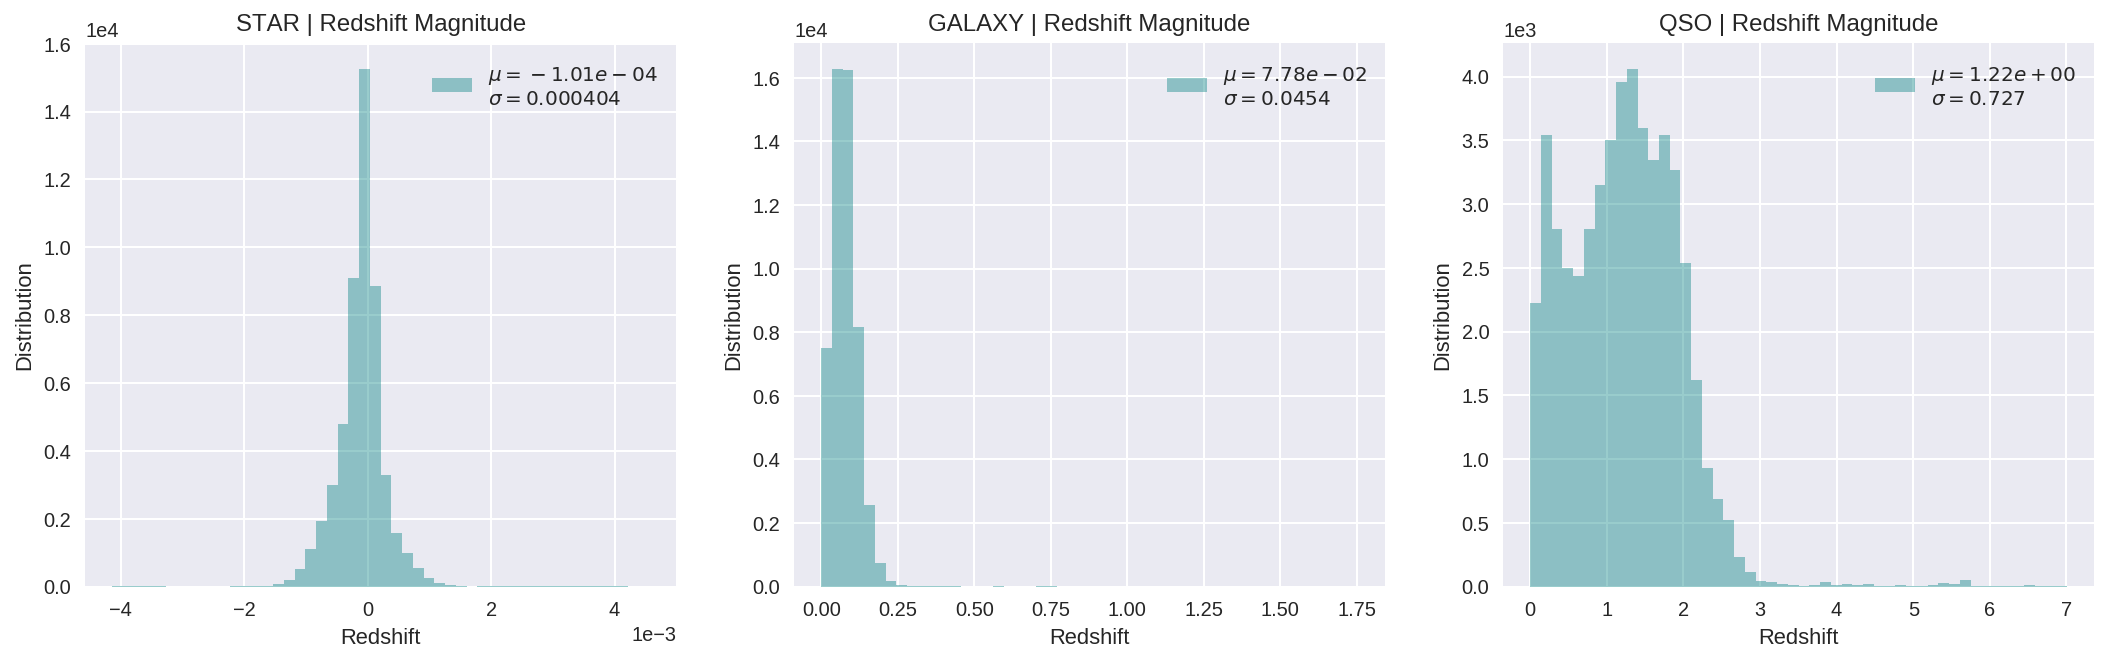

The speed of light, c = 299792.458 [km/sec]

Average Velocity [km/sec]:
STAR   | 30.2
GALAXY | 23309.4
QSO    | 366717.3


In [9]:
plt.figure(figsize=(18,5))

for i, v in enumerate(['STAR', 'GALAXY', 'QSO']):
    plt.subplot(1,3,i+1)
    x = np.array(data[data['class'] == v]['redshift'])
    
    mu = np.mean(x)
    sigma = np.std(x)
    
    sns.distplot(x, label='$\mu={0:10.2e}$\n$\sigma={1:.3}$'.format(mu, sigma),
                kde=False, color='teal');
    plt.title('{} | Redshift Magnitude'.format(v))
    plt.xlabel('Redshift'), plt.ylabel('Distribution')
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,1))
    plt.legend()
    
plt.show()
print('The speed of light, c = {0} [km/sec]'.format(scipy.constants.c / 1000))
print('\nAverage Velocity [km/sec]:')
for i, v in enumerate(['STAR', 'GALAXY', 'QSO']):
    velocity = np.array(data[data['class'] == v]['redshift'] * (scipy.constants.c / 1000))
    print('{0:<6} | {1:.1f}'.format(v, np.abs(np.mean(velocity))))

Data exploration provided insight not only to what makes up the SDSS dataset, but gave adequate information on the importance of features to be used for classification.  The idea is to explore, discover, and study various machine learning algorithms to categorize new celestial objects to be of a star, galaxy, or quasar.

<center>
    <div style="width:100%; height:300px; overflow:hidden;">
      <img src="https://docs.google.com/uc?export=download&id=18Uw73GkIMyq5UZbYbuecBaUcT5-iCUsl" style="width:100%;"/>
    </div>
</center>
[9]	Original image by NASA/ESA Hubble Space Telescope - Hubble Ultra Deep Field

# 3&emsp;Neural Networks  

With a better understanding of the SDSS features, it is possible to begin running various machine learning algorithms.  For this, neural networks will be studied to pick up on numerical patterns, and developed to create a model that adapts and respond to newly introduced patterns.  In order to do this, an adequate model will have to be created with an algorithm that best interprets the data.  

A neural network composes of $m$ layers (representative of neurons) that receives some input, $X$, and links to multiple layers consisting $n$ hidden units.  An activation function is used to manipulate the parameters between each link as the input propagates through the structure.  Each parameter can be thought of as a weight that can be individually mutated to better represent the data.  The input is progressed through the network to an a final set of output, $Y$.  This is the feed-forward action of the network.  However, the network must be trained in order to learn anything.  This is done iteratively updating the weights and  biases within each note, and using optimization algorithms to maximize the likelihood of data as assessed by a loss function that looks at how well the network is learning.  

Visually represented as:  

<center>
  <img src="https://docs.google.com/uc?export=download&id=1algc4FJr6MDUXNlEZjqG7CZnmMWKqTux" style="width:60%;"/>
</center>

The six input features are represented as $X_0 - X_5$ going to an input layer of six units.  These inputs propagate through the $m$ hidden layers of $n$ random units which will be explored in detail below; hence, the ambiguous "..." in the middle.  The last layer feeds into the unit in the output layer - there are only three units, $Y_0 - Y_2$, corresponding to each of the classes in this experiment.  

Exploring various neural networks and algorithms will be needed to find the most accurate representation of the data.  For this, exploration of Scaled Conjugate Gradient, and algorithms provided by PyTorch will be used such as; Adaptive Moment Estimation (Adam), Stochastic Gradient Decent with Momentum, etc.

### 3.1&emsp;Scaled Conjugate Gradient 

Gradient decent is an optimization technique for minimizing a multivariate function.  To find a minimum, the gradient of the loss function can be computed and pursued along the negative direction from a given location.  This is an iterative approach, such that the weights can be updated during backpropagation.  Though, this can often take many steps to find a minimum.  Thus, Scaled Conjugate Gradient (SCG) is introduced to better approximate the function and avoid repetitious steps.  The conjugate gradient is similar to newtons approach of approximating a parameter space with a two-dimensional parabola and calculating the minimum to use as input for the next parameter value until the minimum is found.  Though, with high dimensions in the parameter space, using a line-search with each iteration can be quite expensive - which is why the supervised Scaled Conjugate Gradient algorithm is introduced.  The mathematics behind this can further be found in Martin Moller's Ph.D. Thesis [10].  

A python implementation for Scaled Conjugate Gradient, as seen in the import section for this notebook, has been provided by Dr. Chuck Anderson and modified and added to by myself.  This allows performance and accuracy of this algorithm to be explored with use of Neural Networks.  

The function `sampler` has been defined below to retrieve the desired input features, $X$, and target classifiers, $T$.  This function is dynamic enough to take as lists the column indices to allow multivariate selections.  After reading in the data, the samples with spectral types, $u,g,r,i,z$, containing a value of -9999.00 are removed from data.  Following this, the samples of classes are balanced to improve computation times, and then are split into input and target variables.  The first four corresponding samples are printed below. The classes GALAXY, QSO, and STAR are distinct categories that are label encoded to 0, 1, and 2 respectively.  The function `print_classes` will be used as a reminder of these indicators throughout the notebook.

In [10]:
def sampler(path, a, b):
    data = pd.read_csv(path, sep=',', low_memory=False)
    data = data[(data != -9999.0).all(1)]
    _, c = np.unique(data['class'], return_counts=True)

    data = data.sort_values(by=['class'])[c[0] - c[1] : c[0] + c[1]*2] \
           .sample(frac=1).reset_index(drop=True)

    X = data.iloc[:, np.r_[a]]
    T = [ [item] for item in np.unique(data.iloc[:, np.r_[b]], return_inverse=True)[1] ]

    return np.array(X), np.array(T), data

def print_classes():
    names = np.unique(data['class'])
    print('| ', end='')
    for i in range(0, len(np.unique(T))):
        print(i, '--', '{} | '.format(names[i]), end='')
        
X, T, data = sampler('SkyData.csv', [3, 4, 5, 6, 7, 14], [13])

print(' Input Features\n', '-'*14, '\n', np.around( X[:4],3), 
      '...\n\n Classes\n', '-'*7 , '\n', T[:4], '...\n')
        
print_classes()

 Input Features
 -------------- 
 [[18.678 18.568 18.625 18.436 18.612  1.65 ]
 [19.394 19.175 19.17  18.983 18.987  1.754]
 [19.297 17.599 16.633 16.179 15.823  0.115]
 [19.46  18.251 17.659 17.286 17.117  0.111]] ...

 Classes
 ------- 
 [[1]
 [1]
 [0]
 [0]] ...

| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

Utilizing the neural network and Scaled Conjugate Gradient can be done by use of `get_values`.  This function will instantiate the neural network class defined by the number of inputs, network structure and number of outputs (classifiers).  If partitioning the data, the network can begin to learn by training on some portion of *train* data, and once trained, the neural network can be introduced to new *test* data and produce a predicted output.  Thus, returning the predicted values (`Y`), actual values (`T`), and trained neural network (`nnet`).

In [11]:
def get_values(X, T, network, itr, partition=False):
    if partition: 
        train_f = 0.8
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f), True)
        
        nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1], network, np.unique(T).shape[0]) 
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetworkClassifier(X.shape[1], network, np.unique(T).shape[0])
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet

Actually finding the best network structure using SCG can be a rigorous process.  To visualize how various networks perform, a plot is shown against numerous trials.  Additional insight into the algorithm and how the network is learning is shown as the progress of training occurs.  Such that at the $0^{\text{th}}$ iteration there is significant *error*, and immediately following there is a spike showing an increase of data likelihood.  This is fantastic!  

Each iteration represents a forward feed of inputs and backpropagation updating the weights.  The loss, or data likelihood, can be measured as the product of total probabilities for the $n^{\text{th}}$ sample being of some class given the respective inputs.  In order to maximize this, gradient ascent can be used to update the weights in the direction of the gradient, i.e., increasing log likelihood to find a maxima.  However, since SCG is efficient at finding a minimum, the function to be optimized is the *negative* of the log likelihood [11].  

Thus, to accurately measure the likelihood, the negative error from SCG can be raised to Euler's number, i.e., $e^{-error}$.  This is what is being shown for each network in the plot below.  Various structures that appear to be flat on a lower value of the y-axis can be explained such that the combination of hidden layers result in the optimization function is *stuck* in some local *maxima*.  Contrary to this, some networks perform better and are seen to reach results of roughly 0.95.

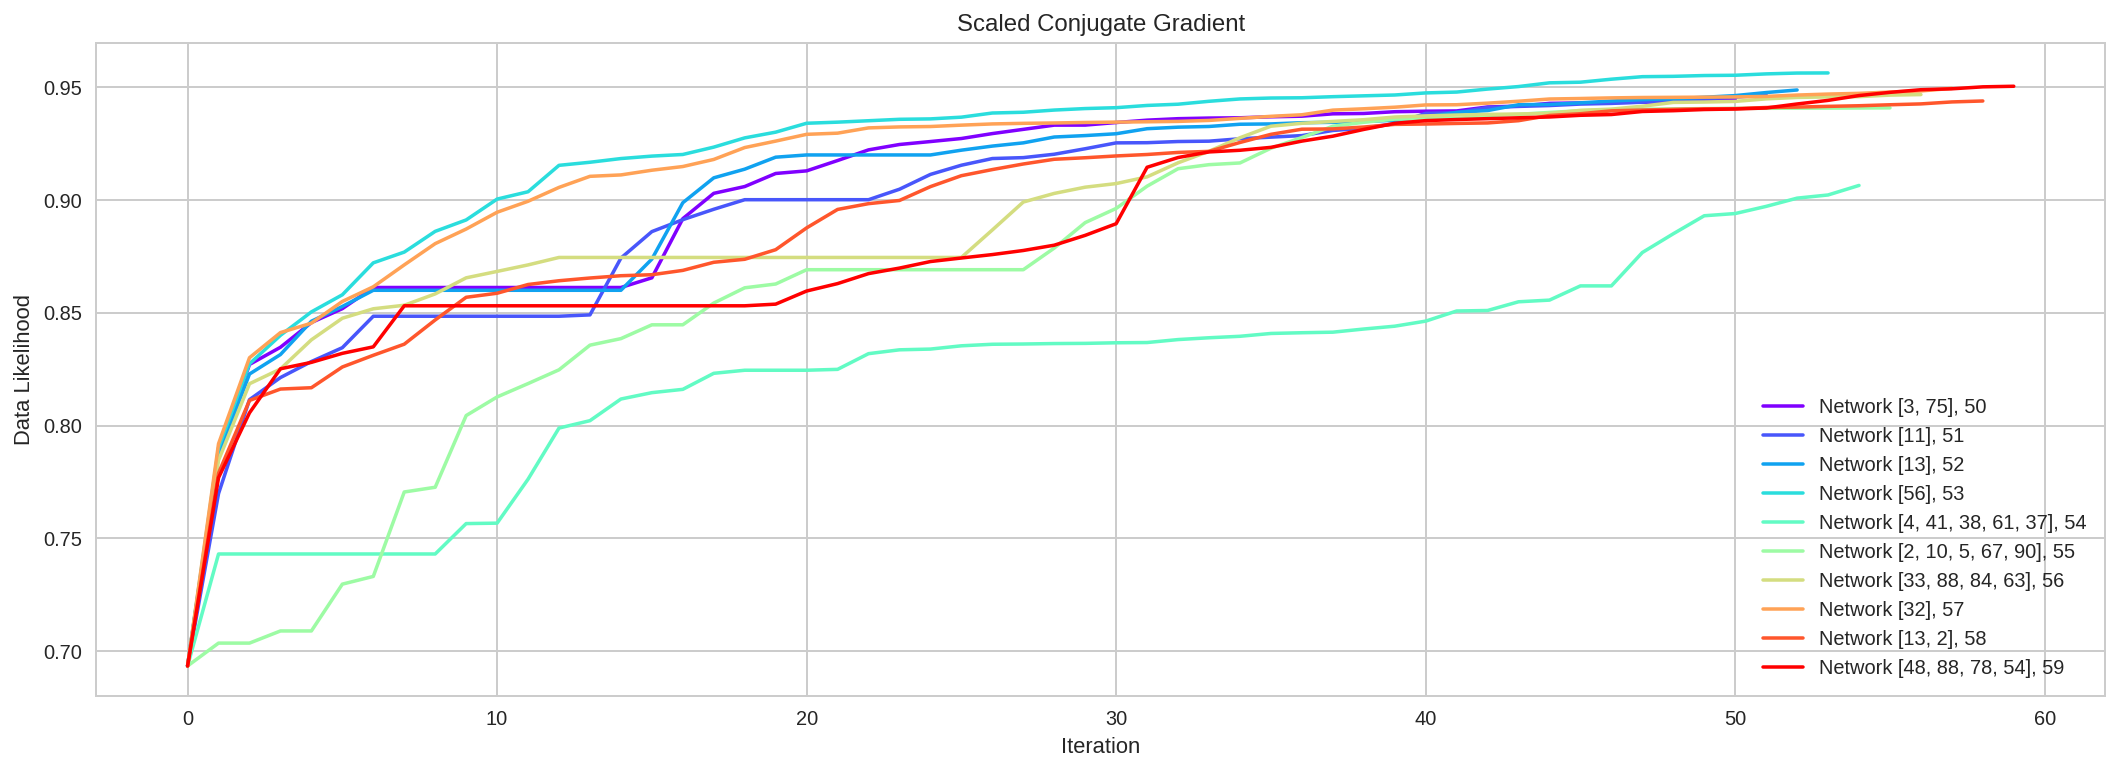

In [12]:
iters = 50
trials = 10
networks = []
it = []
loss = []

f = FloatProgress(min=0, max=trials)
display(f)

for i in range(trials):
    a = random.sample(range(1, 100), np.random.randint(1, 6))
    Y, _T, nnet = get_values(X, T, a, iters)
    networks.append(a)
    it.append(iters)
    loss.append(nnet.getErrorTrace())
    iters = int(1.03 * iters)
    f.value += 1
    
plt.figure(figsize=(18,6))
sns.set_style("whitegrid")
color=iter(cm.rainbow(np.linspace(0,1,trials)))

for i, er in enumerate(loss):
    plt.plot(np.exp(-er), c=next(color), label='Network '+str(networks[i])
                                               +', '+str(it[i]))

plt.title('Scaled Conjugate Gradient')
plt.xlabel('Iteration'), plt.ylabel('Data Likelihood')
plt.legend()
plt.show()

With better understanding of how the accuracy of likelihood increases through various networks and iterations, the process is to be repeated for the finding overall best network and parameters for the data.  The following functions are defined to assist getting more accurate results:

* `trainNNs`
* `summarize`
* `best_network`

Majority of the heavy lifting is done inside `trainNNs` where similar steps of `get_values` is computed.  A difference between the two is that this function repeats the experiment for each structure to allow greater exploration and variability.  Predicted outputs are found for both the *train* and *test* samples to gather information on how accurate the model fits the data.  The other two functions, `summarize` and `best_network`, are combined to retrieve the overall best network found network.

In [13]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations):
    train_p, test_p, timing = [], [], []
    f = FloatProgress(min=0, max=len(hiddenLayerStructures*numberRepetitions))
    display(f)
    for network in hiddenLayerStructures:
        l_train_p, l_test_p = [], []
        sT = time.time()
        for rep in range(0, numberRepetitions):
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1 - trainFraction), True)
            nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1], network, np.unique(T).shape[0])
            nnet.train(Xtrain, Ttrain, numberIterations)

            Ytrain = nnet.use(Xtrain)
            Ytest  = nnet.use(Xtest)

            l_train_p.append( np.sum(Ytrain==Ttrain)/len(Ttrain) )
            l_test_p.append( np.sum(Ytest==Ttest)/len(Ttest) )
            f.value += 1
            
        timing.append((time.time() - sT))
        train_p.append(l_train_p)
        test_p.append(l_test_p)
        
    return [ [hiddenLayerStructures[i], train_p[i], test_p[i], timing[i]]
                for i in range(0, len(hiddenLayerStructures)) ]

def summarize(results):
    for i in range(0, len(results)):
        results[i][1] = np.mean(results[i][1])
        results[i][2] = np.mean(results[i][2])
    
    return results

def best_network(summary):
    max_index = np.argmax( [ [x[2]] for x in summary ] )
    return summary[max_index]

In [14]:
itr = 50
networks = 12
hidden = []
trainFraction = 0.80
numberRepetitions = 2

for i in range(networks):
    a = random.sample(range(1, 100), np.random.randint(1, 6))
    hidden.append(a)
    
results = trainNNs(X, T, trainFraction, hidden, numberRepetitions, itr)
summary = summarize(results)
best    = best_network(summary)

# Only showing the first four networks
pprint(summary[:4], width=100)
print('\nBEST NETWORK | Hidden Layers: {}, Average Training: {:.3f}, ' \
          'Testing: {:.3f}, Took {:.3f} seconds'.format(*best))

[[[36, 8], 0.957869800590426, 0.9571106821106821, 24.63500213623047],
 [[21], 0.9635327429072452, 0.9634169884169884, 12.80555510520935],
 [[37, 78, 41, 85], 0.9597400194663642, 0.9603120978120978, 155.04124283790588],
 [[83, 73, 85, 23, 41], 0.9603392939018798, 0.9596364221364222, 212.3293652534485]]

BEST NETWORK | Hidden Layers: [76, 3, 24], Average Training: 0.972, Testing: 0.970, Took 76.955 seconds


The results look great!  The best network has correctly identified more than 30,000 samples over 97% of the time.  This network structure will be used to retrain the model so that tangible predicted values are retrieved.  With this information it is possible to see what percentage of classes got misinterpreted.  A confusion matrix gives insight to just that.  

Each row / column entry in the matrix represents the percentage of interpreted outputs.  The diagonal represents the accuracy of correctly identified classes, and the corresponding column shows where the remaining outputs fall.

In [15]:
itr = 50
network = best[0]

Y, _T, nnet = get_values(X, T, network, itr, partition=True)

print('Correctly Predicted: % {:.4f}'.format((np.sum(Y==_T)/len(_T)) * 100, '\n'))

_ = ml.confusionMatrix(_T, Y, np.unique(_T))
print('-'*38)
print_classes()

Correctly Predicted: % 97.3263
       0    1    2
    ------------------
 0 | 96.8  0.9  2.3   (10360 / 10360)
 1 |  3.3 96.6  0.1   (10360 / 10360)
 2 |  1.2  0.2 98.6   (10360 / 10360)
--------------------------------------
| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

Initial results from use of Scaled Conjugate Gradient have shown to be quite impressive.  The classification accuracy rounds past 95% confidence, and sometimes found as high as 98%.  This indicates that features such as $u,g,r,i,z,\text{ and } redshift$ all work well to classify specific objects in the night sky.  What is most interesting is that stars had the highest value correctly predicted at nearly 99%, and was misinterpreted for galaxies more often that quasars.  The results for galaxies compliment these findings with often misinterpreting the values as stars.  An explanation for this may be that stars and galaxies share more characteristics than with quasars.  This is reasonable since galaxies are a product of millions or billions of stars, interstellar gas, dust, and other stellar remnants.  Whereas a quasar is described to have significantly more energy and light than galaxy by having a massive black hole in the center.

While the results above area great, it may be possible to better - whether it be by use of accuracy or performance.  In other words, different algorithms will be explored below.

### 3.2&emsp;PyTorch  

The following section will explore [Pytorch](https://pytorch.org), an open-source machine learning library with extensive utilities accessible in Python.  There are countless ways to customize the configuration from selecting different activation functions, optimizers, loss functions, and more depending on the application.  Similar to that used with Scaled Conjugate Gradient (SCG), a probabilistic approach will be taken to gauge maximizing data likelihood.  Thus, the goal will be to explore various models to see how specific algorithms represents the data.  

Foremost, the approach will be slightly more transparent as the code defines components of the neural network upfront.  The function `train_pytorch` will contain the majority of the complex computation - which includes the `Net` class definition that inherits from the torch.nn module and allows creation of a convolutional neural network.  The structure of the network is dynamic enough to take $X_n$ inputs, a hidden layer structure, and $Y_n$ outputs.  Networks are defined as an array of integers with a length as the number of hidden layers, and each index representing the number of units in that layer.  The final output layer applies LogSoftmax to an 3-dimensional input tensor (for each class).  Softmax is a normalized exponential function that mathematically computes the probabilities for each class.  LogSoftmax takes the natural logarithm of this such that the largest value from Softmax is the smallest of LogSoftmax.  Thus, each optimizer will train to minimize the error, and for each iteration the negative log likelihood (NLLLoss) is computed to find the change that is needed to update the weights.

In [16]:
import torch
import torch.nn
import torch.utils.data

def train_pytorch(X, T, networks, learning_rate, iterations, optim, progress=True):
    
    class Net(torch.nn.Module):
        
        def __init__(self, n_in=X.shape[1], networks=[3], n_out=3):
            super(Net, self).__init__()
            self.input = torch.nn.Linear(n_in, networks[0])

            layers = collections.OrderedDict()
            for i in range(len(networks)):
                # Last Intermediary Layer
                if i == (len(networks) - 1):
                    layers[str(i)] = torch.nn.Linear(networks[i], n_out)
                    
                # Intermediary Layers
                else:
                    layers[str(i)] = torch.nn.Linear(networks[i], networks[i+1])
            
            self.hidden = torch.nn.Sequential(layers)
            self.output = torch.nn.LogSoftmax(dim=1)              

        def forward(self, X):
            out = self.input(X)
            out = self.hidden(out)
            out = self.output(out)
            return out
        
    f = FloatProgress(min=0, max=iterations)
    
    if progress:
        display(f)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(X.shape[1], networks, n_out=3).to(device)
    
    criterium = torch.nn.NLLLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                                     betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
    elif optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.90)
    
    tl = []
    for k in range(iterations):
        # Forward Pass
        pred = model(X)
        loss = criterium(pred, T.view(-1))
        
        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tl.append(loss.item())
        f.value += 1
        
    return model, np.array(tl)

In [17]:
X, T, data = sampler('SkyData.csv', [3, 4, 5, 6, 7, 14], [13])
trainFraction = 0.80

Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, 1 - trainFraction), True)

Torch Tensors will be used to hold feature, $X$, and output samples, $T$, from the data.  Similar to Numpy ndarrays, Tensors are multi-dimensional arrays that with the addition of GPU support for accelerated computing.  Therefore, if CUDA can be used on the machine running this notebook, computation times may be decreased.  In order to utilize these functions, one could check for a present graphics card similar to as show below.  

In [18]:
!nvidia-smi

Tue Dec  4 19:11:06 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   48C    P0    36W / 250W |      0MiB / 12066MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Since there exists a GPU, the computations for this experiment will run on CUDA.  To do this, the sample data must be copied to CUDA memory using `.cuda()`.  In order to retrieve this information to something more familiar, such as Numpy, a similar `.cpu()` function is available.

In [19]:
Xtr = torch.Tensor(Xtrain)
Ttr = torch.Tensor(Ttrain).long()
Xtes = torch.Tensor(Xtest)
Ttes = torch.Tensor(Ttest).long()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on', str(device)+'...')

if torch.cuda.is_available():
    Xtr = Xtr.cuda()
    Ttr = Ttr.cuda()
    Xtes = Xtes.cuda()
    Ttes = Ttes.cuda()

Running on cuda...


The function `test_pytorch` is used to train different combinations of network configurations, graph the data likelihood, and test the classification accuracy of each.  A random network structure, learning rate, and training iterations is defined with each trial.  These parameters are used as arguments to `train_pytorch` to return a model represented by the data.  Once trained, the model can be tested with `use_pytorch` which takes some input values, $X$, and target values, $T$, which returns the predicted results, $Y$, and $T$ as Numpy arrays.  Each model is then used to calculate the total amount correctly predicted.  This gives some indication to how well the network learned and preformed on a new set of data.

In [20]:
def use_pytorch(model, X, T):
    with torch.no_grad():
        output = model(X)
        # index of the class with maximum probability.
        _, Y = torch.max(output, 1)   
        Y = Y.cpu().numpy()
        if not isinstance(T, np.ndarray):
            T = T.cpu().numpy()
        T = np.concatenate(T).ravel()
        
    return Y, T

def test_pytorch(optim, runs, iters, lr_bound, Xtr, Ttr):
    er = []
    info = []
    networks = [[3]]
    
    plot_number = 6
    
    f = FloatProgress(min=0, max=runs)
    display(f)
        
    for i in range(runs - 1):
        struct = random.sample(range(5, 25), np.random.randint(1, 6))
        networks.append(struct)
    
    for i in range(runs):
        lr = np.random.randint(1, lr_bound) / 10000
        model, loss = train_pytorch(Xtr, Ttr, networks[i], lr, iters, optim, False)
        Y, T = use_pytorch(model, Xtr, Ttr)
        er.append(loss)
        info.append((lr, iters, np.sum(Y==T)/len(T)))
        iters = int(1.03 * iters)
        f.value += 1

    plt.figure(figsize=(18,10))
    sns.set_style("whitegrid")
    color=iter(cm.rainbow(np.linspace(0,1,plot_number)))

    # Will only graph the first 'plot_number' networks
    for i, pl in enumerate(er[:plot_number]):
        plt.plot(np.exp(-pl), c=next(color), 
                 label='NW: {0} | LR: {1:.3f} | I: {2} '.format(networks[i], info[i][0], info[i][1]))

    plt.title(optim + ' | Learning Rate, Iterations')
    plt.xlabel('Iteration'), plt.ylabel('Data Likelihood')
    plt.legend(fontsize='medium')

    plt.show()
    
    return er, info, networks

### 3.2.1&emsp;Stochastic Gradient Decent

Stochastic Gradient Decent (SGD) is the first optimization algorithm to be tested.  This computes gradient approximations with respect to the weights in attempt to minimize the function - reiterating that this should be the negative of the log likelihood.  A learning rate is applied for all weights, and can be defined by how fast each weight changes.  This is constant for all iterations within SGD.  

With many optimization algorithms, there is a chance of converging to a local minima.  Which introduces the use for momentum, a technique that attempts to accelerate gradients, accumulating a velocity vector in the direction being minimized across iterations [12].

The first six trials are plotted below, showing how the loss changes over training iterations with various configurations.  Similar to SCG, $e^{−error}$ is computed to appropriately represent data likelihood.  This allows understanding to how the network is learning.  It appears that more sporadic lines on the plot below are a product of high learning rates.  Whereas the configurations with low learning rates performed the best, e.g., as seen with the first purple line.

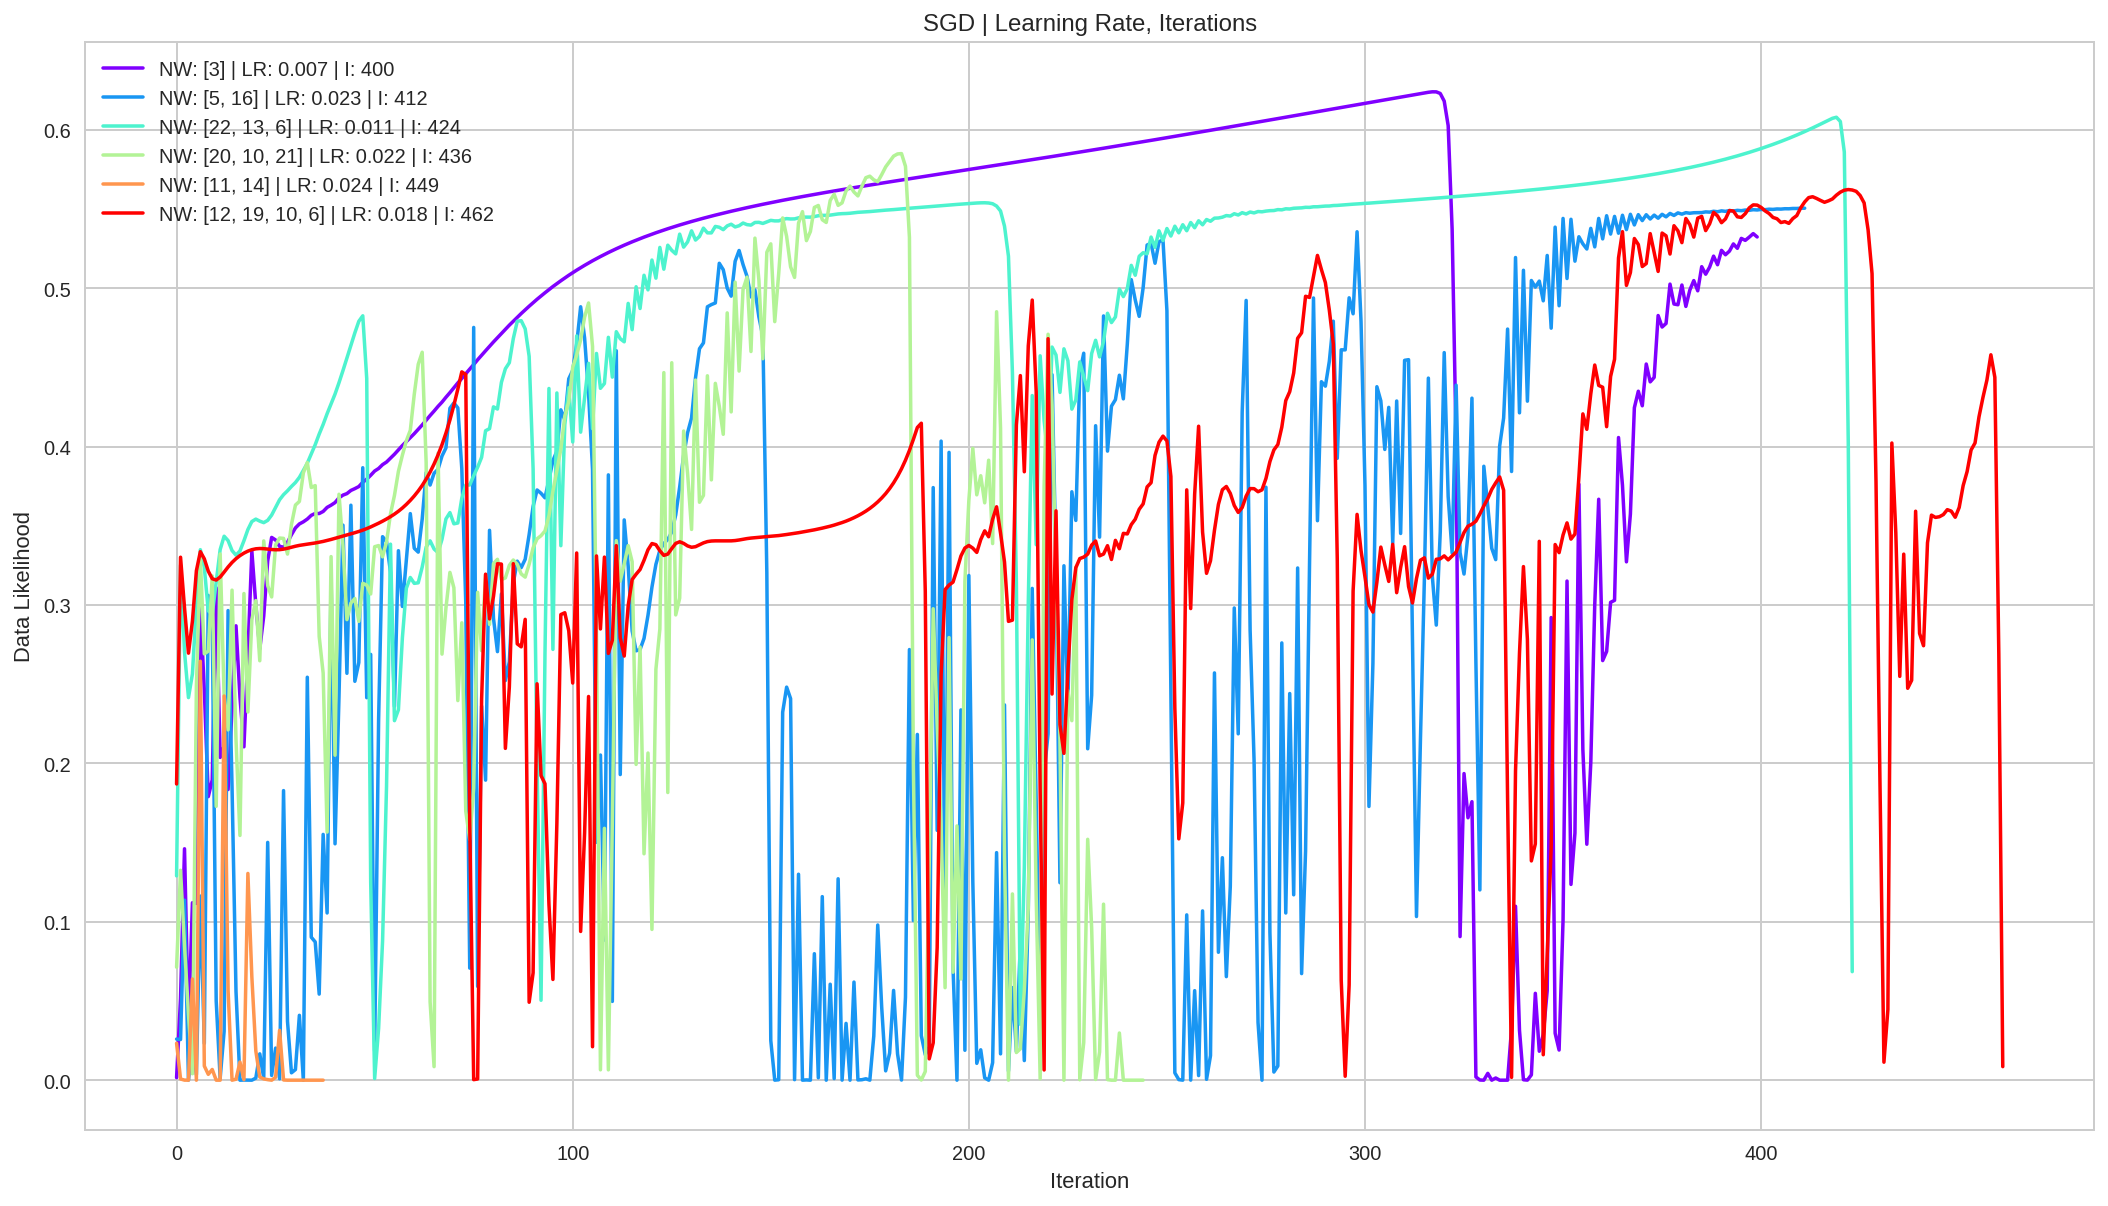

In [21]:
optim = 'SGD'
runs = 20
iters = 400
lr_bound = 250

_, info, networks = test_pytorch(optim, runs, iters, lr_bound, Xtr, Ttr)

The best of the above configurations can be found with the function `get_model`.  This will take the hidden layer structure with the highest correctly predicted value on the test data and run further analysis.  Each iteration will take a random factor of the learning rate and training iterations and attempt to find an optimal arrangement by comparing the number correctly predicted.  The model for the best network is displayed showing the input layer, hidden layer structure, and output layer.

In [22]:
def get_model(optim, info, networks, Xtr, Ttr, Xtes, Ttes):
    i = np.argmax([i[2] for i in info])
    
    net = networks[i]
    lr  = info[i][0]
    itr = info[i][1]
    best_percentage = 0
    best = None
    runs = 10
    
    f = FloatProgress(min=0, max=runs)
    display(f)
    for i in range (runs):  
        model, _ = train_pytorch(Xtr, Ttr, net, lr, itr, optim, False)
        Y, T = use_pytorch(model, Xtes, Ttes)
        new_percentage = np.sum(Y==T)/len(T)
        
        if new_percentage > best_percentage:
            best_percentage = new_percentage
            best = model, lr, itr

        lr = lr * random.uniform(.5, 2)
        itr = int(itr * random.uniform(.5, 1.5))
        f.value += 1
    print('The best Network Structure:\n', best[0])
    return best

best = get_model(optim, info, networks, Xtr, Ttr, Xtes, Ttes)

The best Network Structure:
 Net(
  (input): Linear(in_features=6, out_features=13, bias=True)
  (hidden): Sequential(
    (0): Linear(in_features=13, out_features=3, bias=True)
  )
  (output): LogSoftmax()
)


With help of `display_results` the best network configuration can be used on new data showing the results in a confusion matrix.  

It appears that Stochastic Gradient Decent was unable to get the total number of predicted values above 90% on the test data.  Though it does appear that the highest predicted values on average, quasars, differ from that of SCG, but the results for quasar remain similar.

In [23]:
def display_results(best, X, T):
    model, lr, itr = best
    Y, _T = use_pytorch(model, X, T)

    print('Correctly Predicted: % {:.4f}'.format((np.sum(Y==_T)/len(_T)) * 100),
          '\nLearning Rate: {0:.4f}\nIterations: {1}\n'.format(lr, itr))
    _ = ml.confusionMatrix(_T, Y, np.unique(_T))
    print('-'*38)
    print_classes()
    
display_results(best, Xtes, Ttes)

Correctly Predicted: % 84.8069 
Learning Rate: 0.0038
Iterations: 504

       0    1    2
    ------------------
 0 | 77.9  0.3 21.9   (10360 / 10360)
 1 |  5.7 93.7  0.6   (10360 / 10360)
 2 | 16.8  0.4 82.8   (10360 / 10360)
--------------------------------------
| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

### 3.2.2&emsp;Adaptive Moment Estimation  

Finally, Adaptive Moment Estimation (Adam) is explored as yet another optimization algorithm from PyTorch.  The functions `test_pytorch`, `get_model` and `display_results` from above are used similar by defining the optimizer and initial configurations to find the best structure. 

Adam is an extension of Stochastic Gradient Decent, but differs by adapting as the learning unfolds.  This is by individually computing learning rates for different weights by estimates of the first and second moments of the gradients.  These ideas are descendants of Adaptive Gradient and Root Mean Square Propagation, two other optimization algorithms [13].

Plotting the progress of loss or data likelihood shows how the algorithm learns and changes over iterations.  A simplified network structure with one hidden layer of three units shows to visually be the most consistent approach.  As deeper networks are explored, Adam seems to fluctuate more in an attempt to find a new result that will maximize data likelihood.  This is possibly due to a a high learning rate or too complex of a structure, causing the function to diverge from the minima.  However, this value is better optimized for a learning rate around 0.1 and semi-complex hidden layer structure.

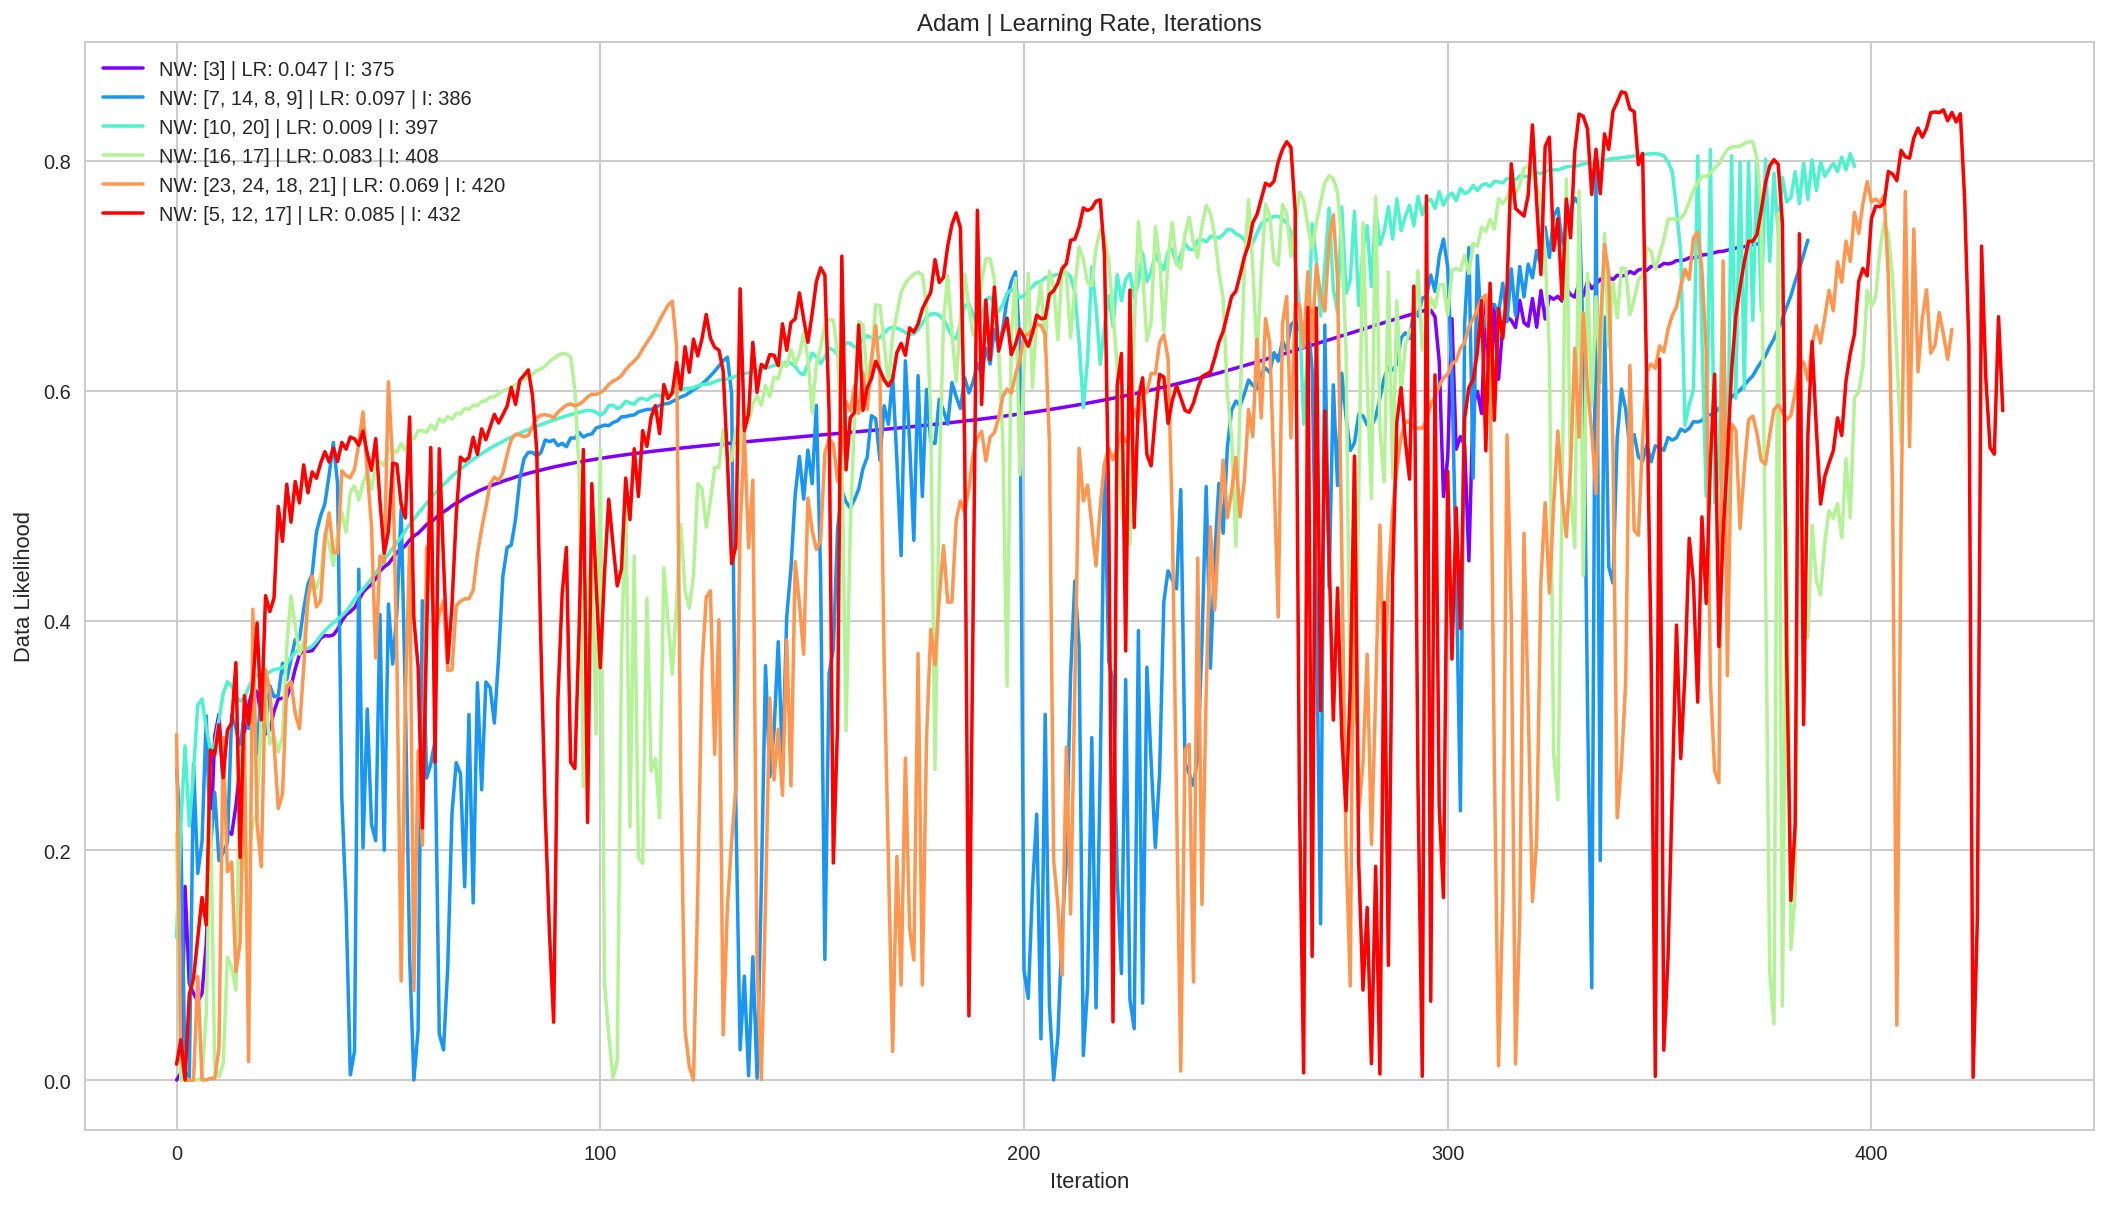

In [24]:
optim = 'Adam'
runs = 20
iters = 375
lr_bound = 1000

_, info, networks = test_pytorch(optim, runs, iters, lr_bound, Xtr, Ttr)

Adam shows to have preformed better than that of SGD in performance and accuracy. The network structure is more abstract with two layers of 17 and 24 units respectively.  The overall values correctly predicted were 96%, with rates following close to Stochastic Conjugate Gradient. While the two algorithms nearly reflect each other, it appears that Adam correctly identified stars the highest overall at 99.3%, but fell behind in classifying galaxies and quasars.

In [25]:
model = get_model(optim, info, networks, Xtr, Ttr, Xtes, Ttes)

display_results(model, Xtes, Ttes)

The best Network Structure:
 Net(
  (input): Linear(in_features=6, out_features=17, bias=True)
  (hidden): Sequential(
    (0): Linear(in_features=17, out_features=24, bias=True)
    (1): Linear(in_features=24, out_features=3, bias=True)
  )
  (output): LogSoftmax()
)
Correctly Predicted: % 96.6667 
Learning Rate: 0.1143
Iterations: 809

       0    1    2
    ------------------
 0 | 96.3  1.1  2.5   (10360 / 10360)
 1 |  5.5 94.4  0.1   (10360 / 10360)
 2 |  0.6  0.0 99.3   (10360 / 10360)
--------------------------------------
| 0 -- GALAXY | 1 -- QSO | 2 -- STAR | 

# 4&emsp;Application

In analysis of the results it can be seen that *on average*, Scaled Conjugate Gradient outperformed both Adam and SGD provided by PyTorch.  As a result, the following code outlines an application for the trained data using a neural network.  This is of importance since by specifying imagery and spectra information for a new celestial object, the classification for said object could be identified!

This is done by taking the best found network configuration in the Neural Networks section of this notebook, training the data, and saving the `Model` with the trained network to a .pickle file by use of [dill](https://pypi.org/project/dill/) - an extension of the pickle module.  This will serialize the weights in the network for that structure allowing for reusability.  Any user thereafter could simple open this file to enter new data, and be presented with a table showing the predicted class.

In [2]:
import dill

class Model:
    
    def __init__(self, network):
        self.network = network
        self.trained_nn = None
        
    def sampler(self, path, a, b, equalize=False):
        '''Retrieve input features and target values for training.'''
        data = pd.read_csv(path, sep=',', low_memory=False)
        data = data[(data != -9999.0).all(1)]
        _, c = np.unique(data['class'], return_counts=True)
        
        if equalize:
            data = data.sort_values(by=['class'])[c[0] - c[1] : c[0] + c[1]*2] \
                   .sample(frac=1).reset_index(drop=True)

        X = data.iloc[:, np.r_[a]]
        T = [ [item] for item in np.unique(data.iloc[:, np.r_[b]], return_inverse=True)[1] ]

        return np.array(X), np.array(T), data

    def train(self, iterations=50, partition=False, equalize=False):
        '''Train the data on the entire dataset, equalized, or partition.'''
        X, T, data = self.sampler('SkyData.csv', [3, 4, 5, 6, 7, 14], [13])

        if partition: 
            train_f = 0.8
            Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f), True)

            nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1], self.network, np.unique(T).shape[0]) 
            nnet.train(Xtrain, Ttrain, iterations)
            Y = nnet.use(Xtest)
            
        else:  
            nnet = nn.NeuralNetworkClassifier(X.shape[1], self.network, np.unique(T).shape[0])
            nnet.train(X, T, iterations)
            Y = nnet.use(X)
        print('Percentage Correctly Identified:', np.sum(Y==T)/len(T))
        self.trained_nn = nnet
    
    def use(self, data):
        '''Use the network with new data.'''
        row = [str(i) for i in data]
        if len(data) == 6:
            Y = self.trained_nn.use(data)[0][0]
            if Y == 0:
                cls = 'GALAXY'
            elif Y == 1:
                clas = 'QUASAR (QSO)'
            else:
                cls = 'STAR'
            row.append(cls)
        else:
            print('ERROR, data = \'u\', \'g\', \'r\', \'i\', \'z\', \'redshift\' values.')
        print('Class Prediction...')
        df = pd.DataFrame(np.array([row]), columns=['u', 'g', 'r', 'i', 'z', 'redshift', 'class'])
        return df.head()
    
    
def save_dill(iterations=50, network=[76, 3, 24], partition=False, equalize=False):
    '''Train Model class with defined network. Then save class to a .pickle file'''
    M = Model(network)
    M.train(iterations, partition, equalize)

    outfile = open('trained_model.pickle', 'wb')
    dill.dump(M, outfile)
    outfile.close()

The network can be saved by use of the `save_dill` function - which instantiates the `Model` class to build a new network and save the trained data to a file named *trained_model.pickle*.  The fractional percentage of the networks accuracy is printed after training is finished.

In [8]:
save_dill(iterations=50, network=[76, 3, 24], partition=False, equalize=False)

Percentage Correctly Identified: 0.9735057350573506


Opening the file and entering the results are as easy as shown below.  The example provided gives spectra and redshift information relating to a known Galaxy.

In [3]:
'''Open the Predicitive Model'''
fp = open('trained_model.pickle', 'rb')
trained_models = dill.load(fp)
fp.close()

'''NEW Imaging and Spectra Information'''
u, g, r, i, z, redshift = 18.62635, 16.82193, 15.97119, 15.57207, 15.23805, 0.06995656

'''Display the Results'''
trained_models.use([u, g, r, i, z, redshift])

Class Prediction...


,u,g,r,i,z,redshift,class
0,18.62635,16.82193,15.97119,15.57207,15.23805,0.06995656,GALAXY


# 5&emsp;Conclusion  

This notebook explored the various imaging and spectra features provided by the Sloan Digital Sky Survey for use of classifying celestial objects.  The use of neural networks made this possible with high accuracy as high as 98%, and resulted in an application that can be used for identifying newly observed celestial objects.  It was evident that Scaled Conjugate Gradient outperformed the other optimization algorithms, and produced the best results.  However, this algorithm does calculate two gradients and takes significantly longer to train than the other algorithms.  Thus, if resource management is an issue, it may be better to use Adam provided by PyTorch to speed up the computation time of training.  Though, once trained there is little to no complexity or time issues with the forward feed process of analyzing new data.

The results show that the spectra data including $u, g, r, i, z,$ and $redshift$ are significant features in identifying stars, galaxies, and quasars.  Though, there are still 2% of results that were incorrectly identified in the dataset when testing.  This may introduce more questions to why these objects were not correctly classified - specifically, those that had more stars and galaxy misidentified as one another.  It possible that these samples are outliers on the main-sequence, or are they of a different composition, or traveling at inconsistent speeds, etc.  Hopefully these questions will continue to motivate further research in the field, and allow further understanding of the universe.

### *Acknowledgements*
I would like to thank Dr. Chuck Anderson (CSU) for sharing resources, knowledge, and advice.  As well as those associated with the Sloan Digital Sky Survey for making this project successful.

# 6&emsp;Resources

[1] *Astronomical Magnitude Systems*.  Retrieved from 
<a href="https://www.astro.umd.edu/~ssm/ASTR620/mags.html" style="text-decoration:none; color:black;">https://www.astro.umd.edu/~ssm/ASTR620/mags.html</a>  

[2] *Understanding SDSS Imaging Data*. Retrieved from
<a href="http://www.sdss3.org/dr10/imaging/imaging_basics.php" style="text-decoration:none; color:black;">http://www.sdss3.org/dr10/imaging/imaging_basics.php</a>  

[3] *Glossary of SDSS Terminology*. Retrieved from
<a href="https://www.sdss.org/dr12/help/glossary/" style="text-decoration:none; color:black;">https://www.sdss.org/dr12/help/glossary/</a>  

[4] Tipler, P. A., Mosca, G. (2008) *Physics for Scientists and Engineers*. New York, NY: W.H. Freeman and Company.  

[5] *Imaging Camera Parameters and Description*. Retrieved from
<a href="http://classic.sdss.org/dr7/instruments/imager/" style="text-decoration:none; color:black;">http://classic.sdss.org/dr7/instruments/imager/</a>  
 
[6] Bassell, M. S. (2005) *Standard Photometric Systems - Annual Review of Astronomy and Astrophysics* 43:1, 293-336  

[7] *Hubble Humason 1936 Redshift Magnitude Relationship*. Retrieved from 
<a href="http://voyages.sdss.org/expeditions/expanding-universe/redshiftmagnitude-relationship/" style="text-decoration:none; color:black;">http://voyages.sdss.org/expeditions/expanding-universe/redshiftmagnitude-relationship/</a>  
 

[8] *Hubble's Law*. Retrieved from 
<a href="https://www.e-education.psu.edu/astro801/book/export/html/1967" style="text-decoration:none; color:black;">https://www.e-education.psu.edu/astro801/book/export/html/1967</a>    

[9] ESA, Hubble. *Hubble Sees Galaxies Galore*. Retrieved from 
<a href="https://www.spacetelescope.org/images/heic0406a/" style="text-decoration:none; color:black;">https://www.spacetelescope.org/images/heic0406a/</a>    

[10] Moller, M.F. (1997) *Efficient Training of Feed-Forward Neural Networks*.  

[11] Anderson, Chuck. *Classification with Linear Logistic Regression*. Retrieved from 
<a href="http://www.cs.colostate.edu/~anderson/cs440/doku.php" style="text-decoration:none; color:black;">http://www.cs.colostate.edu/~anderson/cs440/doku.php</a>  

[12] Sutskever1, I.,  Martens J., Dahl G., & Hinton G. *On the importance of initialization and momentum in deep learning*. Retrieved from
<a href="http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf" style="text-decoration:none; color:black;">http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf</a>    

[13] Kingma, D. K., Ba J. (2014) *Adam: A Method for Stochastic Optimization*. Retrieved from 
<a href="https://arxiv.org/abs/1412.6980" style="text-decoration:none; color:black;">https://arxiv.org/abs/1412.6980</a> 

In [7]:
import io
from nbformat import current
import glob
import warnings
warnings.filterwarnings('ignore')

nbfile = glob.glob('stock-starsearch.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
    
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
    
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
        
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file stock-starsearch.ipynb is 5800
